**YouTube Tech Services Shorts video Generator from Longform**<br>
The idea is to allow creation of Shorts content from longform at scale, mimicking something similar to a package from the package uploader.

Requirements:


*   create in GoogleDrive a folder called yt-longform-2-shorts
*   upload in the folder all the longform videos you want to transform in shorts
*   upload a input.csv file with the following fields:


>  1.   project: the name of the output file. Each row marked with the same label will be added to the same short
>  2.   video: the filename of the video source for the segment
>  3. the starting timestamp of the segment to cut. Format: 00:00:00
>  4. sec_len: the lenght in seconds of the segment
>  5. window: an orizontal video is divided in 5 different windows/vertical slice, partially overlapping. They are numbered from 0 to 4. 0-2-4 are contiguous, 1-3 are overlapping with the others (see images below).


Your CSV file should look like this:

project,video,start,sec_len,window<br>
short1,input_video_1.mp4,0:00:01,10,0<br>
short1,input_video_1.mp4,0:00:01,9,1<br>
short2,input_video_1.mp4,0:00:01,8,2<br>
short2,input_video_1.mp4,0:00:01,7,3<br>
short2,input_video_1.mp4,0:00:01,6,4<br>
<br>

This will generate 2 shorts from the same video, on different slices

* Click on the "Connect" button on the right upper corner
* Click on "Runtime" -> "Run all"
* Authorize GDrive access when propted and wait for the script to run

The script will produce, for each project, a vertical video (even more than 60 seconds) concatenating the various slices, with name {project_name}_output.mp4



# Windowing example
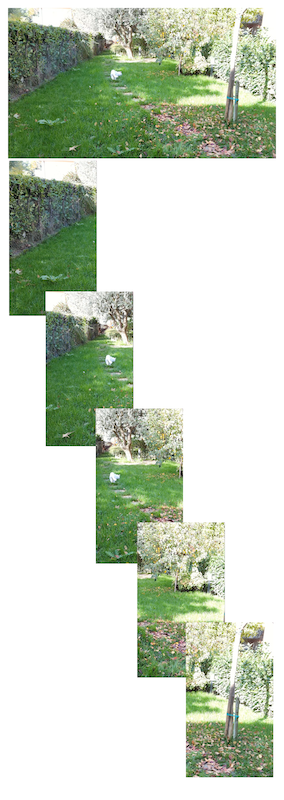

**The following cell will connect to your GoogleDrive. It will ask the permission to access your data.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**The following cell process the csv as input and create the structure of the folders in Colab storage to allocate temporary files**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/yt-longform-2-shorts/input.csv')
v_project_list = df.values.tolist()
for x in v_project_list:
  !mkdir -p {x[0]}

**The following cell does most of the heavy lifting on the processing.
It creates every single slice (one for each line of the CSV), first cutting the segment and then slicing the relevant vertical section.
Note: it seems to work better splitting the 2 operations in terms of performance on Colab instead or running ffmpeg only once.
The cell then creates the list of files that should be concatenated.**

In [ ]:
v_line_number = 0
for lv in v_project_list:
  v_project_name = lv[0]
  v_file_input_name = "/content/drive/MyDrive/yt-longform-2-shorts/"+lv[1]
  v_interval_start = lv[2]
  v_interval_duration_sec = lv[3] #max 59

  v_file_output_name = 'output_cut_'+v_interval_start.replace(":", "")+'_' \
                          + str(v_interval_duration_sec)+'_'+str(v_line_number)

  v_portion_split = lv[4] #video is splitted in 5 partially overlapping slices
  v_line_number = v_line_number + 1

  !ffmpeg -hide_banner -loglevel error -i {v_file_input_name} \
                      -ss {v_interval_start} -t 00:00:{v_interval_duration_sec}\
                      -c:v copy -c:a copy -max_muxing_queue_size 1024 \
                      {v_project_name}/{v_file_output_name}.mp4

  !ffmpeg -hide_banner -loglevel error -i \
                      {v_project_name}/{v_file_output_name}.mp4 -vf\
                      crop=ih*9/16:ih:iw/6*{v_portion_split} \
                      -max_muxing_queue_size 1024 \
                      {v_project_name}/{v_file_output_name}_cropped.mp4

  with open(v_project_name+'/manifest.txt', 'a+') as testwritefile:
    testwritefile.write('file \''+v_file_output_name+"_cropped.mp4\'\n")

**This cells process the manifest file generated previously and concatenates all the slices, producing one final file for each subset. It includes a simple logic to avoid to process twice the same file.**

In [ ]:
lv_already_processed = []
for lv in v_project_list:
  v_project_name = lv[0]
  if lv[0] not in lv_already_processed:
    lv_already_processed.append(lv[0])
    !ffmpeg -hide_banner -loglevel error -f concat -i \
                      {v_project_name}/manifest.txt -c copy \
                      {v_project_name}/{v_project_name}_output.mp4
    !cp {v_project_name}/{v_project_name}_output.mp4 \
                      /content/drive/MyDrive/yt-longform-2-shorts/

print("Execution Completed! Check your GDrive account")

Execution Completed! Check your GDrive account


**Do you want to help us in improve this script and understand its usage? If you upload the shorts generated with this tool on YouTube, please insert the hashtag #ytptmos_shortscutter.**